# LVIT Calibration

##### Made by: Nick Schwartz
 Last Updated: 8/14/2023

In [ ]:
pip install pyserial

# Instructions

## Before Using this Program
#### First trial after connecting LVIT: "Test_VMeasurement"
Upload the Arduino file "Test_VMeasurement.ino" on the Arduino software. Wait to see if data is recorded, then Close out the program.
    Subsequent trials can ignore this step.

## First trial of each day: "LVIT Calibration Test"
Use python file "LVIT Calibration Test". Replace the port name with the port the LVIT is attached to. Replace the heights with the values of the calibration blocks. Run the program and place the corresponding block when prompted. Shut down the Kernel.  

#### Main Recording Program: "LVIT Test"
Use python file "LVIT Test". Replace the port name with the port the LVIT is attached to. Input y-intercept and slope from Calibration Test. Replace minutes with how many minutes will be used. 

In [2]:
import serial
import time
from datetime import datetime
import pdb
import csv
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Set Up

Set serialPortName as the port defined by the Arduino Software.

In [1]:
#Setting up the LVIT Acquisition
serialPortName = 'COM6'
serialPort = serial.Serial(
    port=serialPortName, baudrate=9600, bytesize=8, timeout=2, stopbits=serial.STOPBITS_ONE
)

#Setting up the heights. (abs difference between reference position and current position)
heights = [0, .05, .1, .15, .2, .25, .3]
names = ['0', '.05', '.1', '.15', '.2', '.25', '.3']

NameError: name 'serial' is not defined

In [4]:
#Set Up for for loop

serialString = ""  # Used to hold data coming over UART

# time.time() returns seconds since Jan 1 1970 00:00 (Epoch Time)
time_start = time.time()

# Get a timestamp for the file name
now = datetime.now()
current_time = now.strftime("%m-%d-%y_%H-%M-%S")

#number of minutes to run LVIT
minutes = 1
duration = 60 * minutes

#Set Files list
files = []

# Main Loop

In [5]:
#Main Loop
files = []
for name in names:
    answer = input("Proceed with height {0}.\n Hit Enter to continue\n".format(name))
    if answer.lower() != "":
        break    
    
    serialString = ""  # Used to hold data coming over UART

    # time.time() returns seconds since Jan 1 1970 00:00 (Epoch Time)
    time_start = time.time()

    # Get a timestamp for the file name
    now = datetime.now()
    current_time = now.strftime("%m-%d-%y_%H-%M-%S")
    
    #Set Filename
    output_filename = "Calibration_Data_{0}.csv".format(name)
    
    time_last_log = time.time()
    time_now = time.time()
    time_elapsed = time_now - time_start
    
    f = open(output_filename, "w")
    
    while time_elapsed < duration + 1:
  
      time_now = time.time()
      time_elapsed = time_now - time_start

      # Wait until there is data waiting in the serial buffer
      if serialPort.in_waiting > 0:

        # Read data out of the buffer until a carraige return / new line is found
        serialString = serialPort.readline(16)
        serial_output = serialString.decode("Ascii")

        # If one second has elapsed since last time you logged output, then
        # it's time to log another weight value.
        time_since_last_log = time_now - time_last_log

        if time_since_last_log >= .45:
          # Reformat output from '  -23.8g\n' to '-23.8'
          weight = serial_output

          weight = weight.replace("g\n", "")


          # Print the contents of the serial data to the file
          try:
            output = "{0},{1}\n".format(round(time_elapsed, 3), weight)
            print(output)
            output = output.replace("Voltage: ","")
            output = output.replace("V","")
            f.write(output)
          except:
            pass
          time_last_log = time_now

    f.close()
    
    files.append(output_filename)
    
    f.close()


Proceed with height 0.
 Hit Enter to continue

0.459,0.31281


0.917,0.30303


1.372,0.31281


1.831,0.31281


2.285,0.30303


2.744,0.30303


3.199,0.30303


3.657,0.31281


4.112,0.30303


4.571,0.30303


5.025,0.30303


5.484,0.30303


5.939,0.31281


6.397,0.30303


6.852,0.31281


7.311,0.30303


7.765,0.30303


8.224,0.31281


8.679,0.30303


9.137,0.31281


9.592,0.30303


10.051,0.30303


10.505,0.28348


10.964,0.31281


11.419,0.31281


11.878,0.30303


12.332,0.30303


12.791,0.31281


13.246,0.31281


13.704,0.31281


14.159,0.31281


14.618,0.31281


15.072,0.31281


15.527,0.30303


15.986,0.30303


16.44,0.30303


16.899,0.31281


17.354,0.31281


17.812,0.31281


18.267,0.31281


18.726,0.31281


19.18,0.30303


19.639,0.31281


20.098,0.31281


20.552,0.31281


21.011,0.31281


21.466,0.31281


21.924,0.32258


22.379,0.32258


22.838,0.31281


23.292,0.31281


23.751,0.32258


24.206,0.31281


24.665,0.31281


25.119,0.32258


25.578,0.31281


26.033,0.31281


26.491,

In [6]:
print(files)

['Calibration_Data_0.csv', 'Calibration_Data_1.csv', 'Calibration_Data_2.csv', 'Calibration_Data_3.csv', 'Calibration_Data_4.csv', 'Calibration_Data_5.csv']


In [4]:
files = ['Calibration_Data_0.csv', 'Calibration_Data_1.csv', 'Calibration_Data_2.csv', 'Calibration_Data_3.csv', 'Calibration_Data_4.csv', 'Calibration_Data_5.csv']

# Data Reading

In [5]:
# Initialize lists for x values, y values, mean y values, and standard deviations
Time_list = []
Voltage_list = []
mean_V_list = []
mean_Voltage_list = []
std_V_list = []
V_rms_list = []
V_rms = []

# Loop through each CSV file and extract x and y values
for i, file in enumerate(files):
    print('{0}'.format(file))
    Time = []
    Voltage = []
    with open(file, 'r') as csv_file:
        csv_reader = csv.reader(csv_file)
        next(csv_reader)  # skip header row
        for row in csv_reader:
            #print(row)
            if row == []:
                continue
            if row[0] == '' or row[1] == '' or row == '':
                continue 
            Time.append(float(row[0]))
            Voltage.append(float(row[1]))
    #Voltage = [i * 25.4 for i in Voltage]
    Time_list.append(Time)
    Voltage_list.append(Voltage)
    
    mean_V = np.mean(Voltage)
    mean_Voltage = [mean_V for j in range(len(Voltage))]
    
    #V_rms = [np.sqrt( (i - mean_V)**2 / len(Voltage) ) for i in Voltage]
    V_rms = [(i - mean_V)**2  for i in Voltage]
    V_rms = np.sqrt( np.sum(V_rms) / len(Voltage))
    
    V_rms_list.append(V_rms)

    mean_Voltage_list.append(mean_Voltage)
    
    std_V = np.std(Voltage)
    
    mean_V_list.append(mean_V)
    std_V_list.append(std_V)
    


print(mean_V_list)
print(V_rms_list)

Calibration_Data_0.csv


FileNotFoundError: [Errno 2] No such file or directory: 'Calibration_Data_0.csv'

# Plots

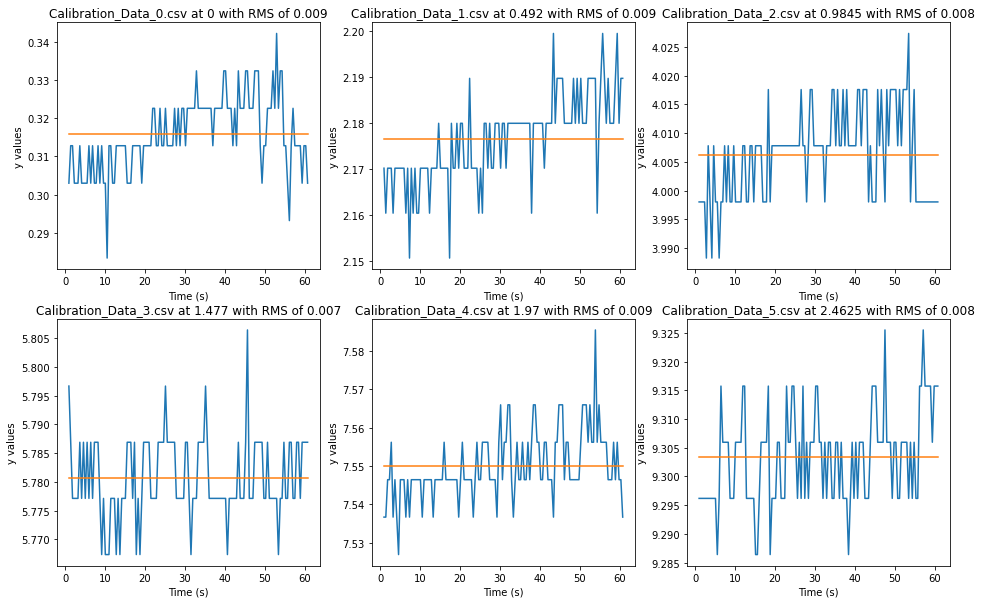

In [9]:
# Plot each graph on a subplot
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(16, 10))
axs = axs.flatten()
for i in range(len(files)):
    axs[i].plot(Time_list[i], Voltage_list[i])
    axs[i].plot(Time_list[i], mean_Voltage_list[i])
    axs[i].set_xlabel('Time (s)')
    axs[i].set_ylabel('y values')
    axs[i].set_title("{0} at {1} with RMS of {2}".format(files[i],round(heights[i],4),round(V_rms_list[i],3)))


6
6
5


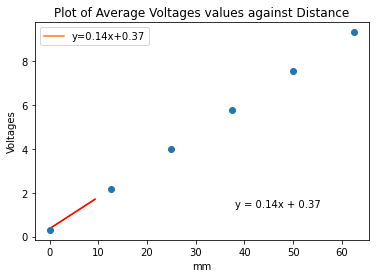

y = 0.14x + 0.37


In [10]:
# Plot the average y values against the x values with error bars and trendline

#Known values in Inches that are converted into mm.
x_values = heights
x_values = [i * 25.4 for i in x_values]
y_values = mean_V_list

print(len(x_values))
print(len(y_values))
fig, ax = plt.subplots()
ax.errorbar(x_values, y_values, yerr=std_V_list, fmt='o')

# Fit a polynomial regression line to the data
coefficients = np.polyfit(x_values, y_values, 1)
polynomial = np.poly1d(coefficients)
x_range2 = np.linspace(0, y_values.pop(), 90)
y_range2 = polynomial(x_range2)

# Plot the regression line
ax.plot(x_range2, y_range2, label=f'y={polynomial.coeffs[0]:.2f}x+{polynomial.coeffs[1]:.2f}')
ax.plot(x_range2, y_range2, 'r')

# Add axis labels, a title, and a legend to the graph
ax.set_xlabel('mm')
ax.set_ylabel('Voltages')
ax.set_title('Plot of Average Voltages values against Distance')
ax.legend()

# Display the equation of the trendline on the graph
eq = f'y = {polynomial.coeffs[0]:.2f}x + {polynomial.coeffs[1]:.2f}'
ax.text(0.6, 0.15, eq, transform=ax.transAxes)

plt.show()


# Final Measurement

Copy the first number and paste onto the Slope area on the Test file, Copy the second number and paste onto the Intercept area on the Test file.

In [ ]:
#Equation of the Best Fit Line
print(eq)
print(polynomial.coeffs[0])
print(polynomial.coeffs[1])